In [114]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### Create a csv with all teams and conferences since 2014

In [35]:
import time

years = np.arange(2014, 2024)
dfs = []
for year in years :

    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_standings.html'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'lxml')
    while soup.find(class_ = 'thead') is not None:
        soup.find(class_ = 'thead').decompose()
    east_table, west_table = [t for t in soup.find_all('table') if 'divs_standings' in t.get('id')]

    for table, name in zip([east_table, west_table], ['East', 'West']) :
        df = pd.read_html(str(table))[0].rename(columns = {f'{name}ern Conference': 'Team'})
        df['Tm'] = [str(x).split('/')[2] for x in table.find_all('a', href = True)]
        df['Year'] = len(df) * [year]
        df['Conference'] = len(df) * [name]
        dfs.append(df[['Tm', 'Year', 'Conference']])
    time.sleep(5)

In [48]:
confs = pd.concat(dfs)
confs.to_csv('data/conferences_2014-2023.csv', index = None)

### Function to evaluate models

In [116]:
def evaluate_model(path, years) :

    res = pd.read_csv(path)
    confs = pd.read_csv('data/conferences_2014-2023.csv')
    res = res.merge(confs, on = ['Year', 'Tm'], how = 'left')

    metrics = np.zeros((len(years), 4))
    for i, year in enumerate(years) :
        res_yr = res.groupby('Year').get_group(year)
        mae = np.abs(res_yr['Pred'] - res_yr['Real']).mean()
        r2 = r2_score(res_yr['Real'], res_yr['Pred'])

        res_yr_east = res_yr.copy()[res_yr['Conference'] == 'East']
        res_yr_west = res_yr.copy()[res_yr['Conference'] == 'West']

        res_yr_east['Rank'] = res_yr_east['Real'].rank(ascending = False, method = 'min')
        res_yr_east['PredRank'] = res_yr_east['Pred'].rank(ascending = False, method = 'min')

        res_yr_west['Rank'] = res_yr_west['Real'].rank(ascending = False, method = 'min')
        res_yr_west['PredRank'] = res_yr_west['Pred'].rank(ascending = False, method = 'min')

        rank_mae_east = np.abs(res_yr_east['PredRank'] - res_yr_east['Rank']).mean()
        rank_mae_west = np.abs(res_yr_west['PredRank'] - res_yr_west['Rank']).mean()

        metrics[i, :] = np.array([r2, mae, rank_mae_east, rank_mae_west])

    return metrics

In [118]:
years = np.arange(2017, 2024)

In [148]:
res_lr = evaluate_model('data/pred_test_LR.csv', years)
res_rf = evaluate_model('data/pred_test_RF.csv', years)
res_xgb = evaluate_model('data/pred_test_XGB.csv', years)

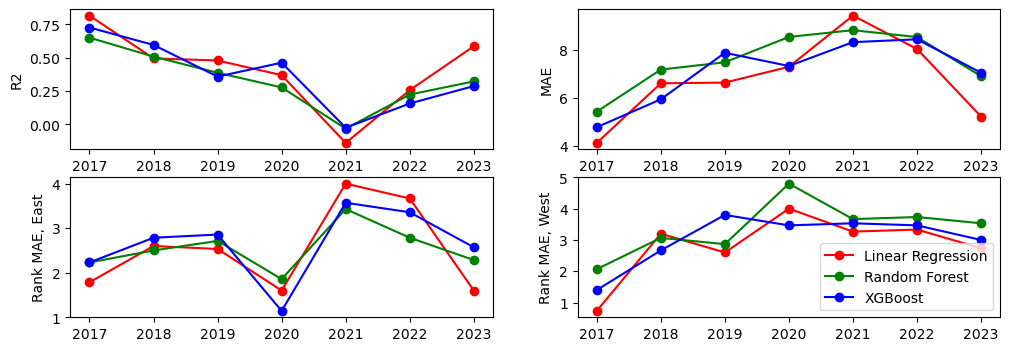

In [158]:
fig, axs = plt.subplots(2, 2, figsize = (12, 4)); axs = axs.flatten()

for j, (ax, ttl) in enumerate(zip(axs, ['R2', 'MAE', 'Rank MAE, East', 'Rank MAE, West'])) :
    ax.plot(years, res_lr[:,j], 'r-o', label = 'Linear Regression')
    ax.plot(years, res_rf[:,j], 'g-o', label = 'Random Forest')
    ax.plot(years, res_xgb[:,j], 'b-o', label = 'XGBoost')
    ax.set_ylabel(ttl)

plt.legend()
plt.show()